# Integrasi Model K-Nearest Neighbors (KNN) dengan Hyperparameter Tunning Optuna Untuk Memprediksi Penyakit Liver - Dadan Ahmad Dani

### Library

In [1]:
#Install Optuna
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.3 MB/s eta 0:00:00


In [2]:
#Data
import numpy as np
import pandas as pd
from scipy import stats
#Visualisasi
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# Scale
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler,RobustScaler
# Model KNN
from sklearn.neighbors import KNeighborsClassifier
# Hyperparameter Tuning
import optuna
from imblearn.pipeline import make_pipeline
#Model Selection
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
#Resample Data
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
#Matriks Evaluasi
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#Warning
import warnings
warnings.filterwarnings('ignore')

### Load Dataset

In [3]:
#load dataset csv
liver_df = pd.read_csv('Indian Liver Patient Dataset (ILPD).csv')
#tampilkan datasetnya
liver_df.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G,Class
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [4]:
#Jumlah Baris ,Kolom, dan Tipe Data
#Jumlah rows dan column
print(f'Dataset ini memiliki {liver_df.shape[0]} rows and {liver_df.shape[1]} columns\n')
# ----Tipe Data------------------------
#cek data types untuk masing-masing kolom
liver_df.info()

Dataset ini memiliki 583 rows and 11 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      583 non-null    int64  
 1   Gender   583 non-null    object 
 2   TB       583 non-null    float64
 3   DB       583 non-null    float64
 4   Alkphos  583 non-null    int64  
 5   Sgpt     583 non-null    int64  
 6   Sgot     583 non-null    int64  
 7   TP       583 non-null    float64
 8   ALB      583 non-null    float64
 9   A/G      579 non-null    float64
 10  Class    583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [5]:
#kolom numerik
feature_numeric = ['Age','TB','DB','Alkphos','Sgpt','Sgot','TP','ALB','A/G']
#kolom klasifikasi Liver dan Non Liver
# 1: Liver dan 2:Non-Liver
liver_df['Class'].replace({1:"Liver" , 2:"Non-Liver"},inplace = True)
target_label=['Class']
#data untuk pasien Liver
df_liv=liver_df[(liver_df['Class']=="Liver")]

### Statistik Deskriptif

In [6]:
#deskripsi fitur numerik
liver_df[feature_numeric].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,583.0,44.746141,16.189833,4.0,33.0,45.00,58.0,90.0
TB,583.0,3.298799,6.209522,0.4,0.8,1.00,2.6,75.0
DB,583.0,1.486106,2.808498,0.1,0.2,0.30,1.3,19.7
Alkphos,583.0,290.576329,242.937989,63.0,175.5,208.00,298.0,2110.0
Sgpt,583.0,80.713551,182.620356,10.0,23.0,35.00,60.5,2000.0
Sgot,583.0,109.910806,288.918529,10.0,25.0,42.00,87.0,4929.0
TP,583.0,6.483190,1.085451,2.7,5.8,6.60,7.2,9.6
ALB,583.0,3.141852,0.795519,0.9,2.6,3.10,3.8,5.5
A/G,579.0,0.947064,0.319592,0.3,0.7,0.93,1.1,2.8


### Perbandingan Jumlah Pasien Liver dan Non Liver

In [7]:
# Deskripsi Pasien
#Perbandingan Jumlah Pasien Liver dan Non Liver (%)
def plot_pie_liver_patient():
    labels1 = 'Liver','Non-Liver'
    liver_df['Class'].value_counts().plot.pie(explode=[0.1,0.1],labels=labels1, autopct='%1.1f%%',shadow=True,figsize=(3,3));
    plt.title("Perbandingan Pasien Liver dan Non-Liver(%)")

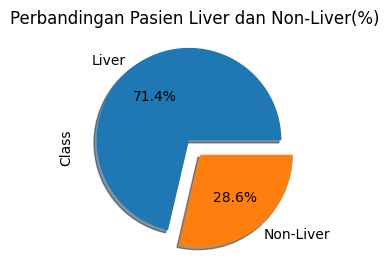

In [8]:
plot_pie_liver_patient()

### Perbandingan Jumlah Pasien Liver Berdasarkan Jenis Kelamin

In [9]:
#Perbandingan Jumlah Pasien Liver Berdasarkan Jenis Kelamin (%)
def plot_pie_liver_gender():
    labels_gend = 'Male','Female'
    df_liv['Gender'].value_counts().plot.pie(explode=[0.1,0.1],labels=labels_gend, autopct='%1.1f%%',shadow=True,figsize=(3,3));
    plt.title("Perbandingan Pasien Liver Berdasarkan Gender",fontsize=10)

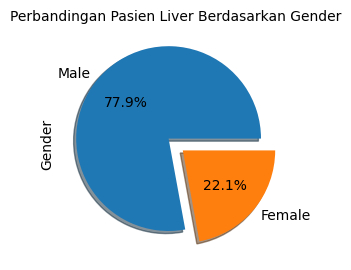

In [10]:
plot_pie_liver_gender()

### Distribusi Pasien Liver Berdasarkan Usia

In [11]:
#Distribusi Pasien Liver Berdasarkan Usia
def plot_hist_age_patient():
    plt.figure(figsize=(3,3))
    sns.histplot(df_liv['Age'], color="#9bd0b7")
    plt.title(f'Distribusi Pasien Liver Berdasarkan Usia', fontsize=10)
    plt.xlabel('Usia')
    plt.xticks(fontsize=10)
    plt.ylabel('Jumlah')
    plt.yticks(fontsize=10)

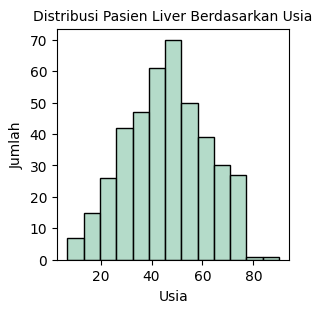

In [12]:
plot_hist_age_patient()

### Exploratory Data Analysis (EDA)--Multivariate Analysis

In [13]:
def plot_corr():
	plt.figure(figsize=(8,8))
	sns.heatmap(liver_df[feature_numeric].corr(),annot=True,cmap = 'terrain')

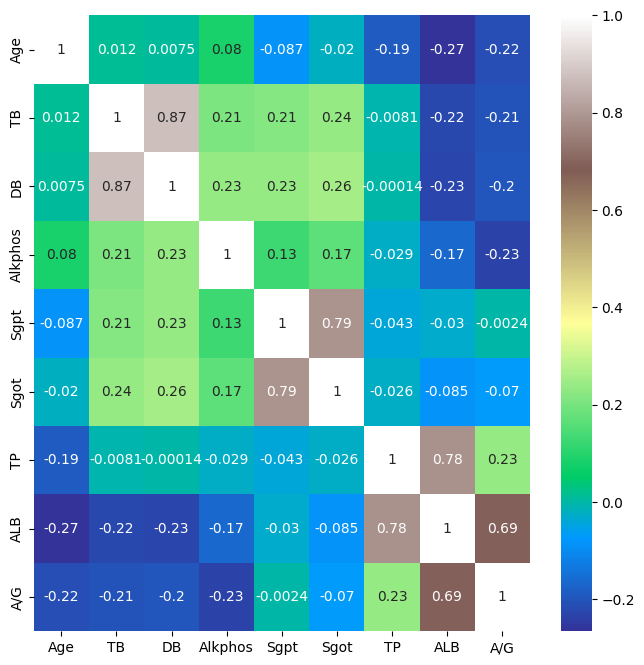

In [14]:
plot_corr()

### Exploratory Data Analysis (EDA)- EDA-Menangani Missing Value

In [15]:
#cek jumlah missing value tiap kolom
print('Jumlah Missing Value Tiap Kolom')
liver_df.isnull().sum()

Jumlah Missing Value Tiap Kolom


Age        0
Gender     0
TB         0
DB         0
Alkphos    0
Sgpt       0
Sgot       0
TP         0
ALB        0
A/G        4
Class      0
dtype: int64

In [16]:
#isi 4 kolom A/G yg kosong dengan menggunakan nilai rata-rata (mean) dari nilai A/G
liver_df["A/G"] = liver_df["A/G"].fillna(liver_df["A/G"].mean())
#cek kembali hasilnya
print('Setelah Penanganan')
liver_df.isnull().sum()

Setelah Penanganan


Age        0
Gender     0
TB         0
DB         0
Alkphos    0
Sgpt       0
Sgot       0
TP         0
ALB        0
A/G        0
Class      0
dtype: int64

### Exploratory Data Analysis (EDA)- Visualisasi dan penanganan Outlier

In [17]:
def plot_hist_box(X_num):
      plot_number = 1
      plt.figure(figsize=(6,18))
      plt.subplots_adjust(hspace=1, wspace=0.05)
      for col in X_num.columns:

          plt.subplot(9, 2, plot_number)
          sns.histplot(X_num[col], color="#9bd0b7")
          plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
          plt.title(f'{col.capitalize()} histogram', fontsize=10)
          plt.xlabel('')
          plt.xticks(fontsize=6)
          plt.ylabel('')
          plt.yticks(fontsize=6)

          plt.subplot(9, 2, plot_number+1)
          sns.boxplot(x=X_num[col], color='#badfda', width=0.7, linewidth=0.6)
          plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
          plt.title(f'{col.capitalize()} boxplot', fontsize=10)
          plt.xlabel('')
          plt.xticks(fontsize=6)
          plt.ylabel('')
          plt.yticks(fontsize=6)
          plot_number = plot_number+2
      plt.show()

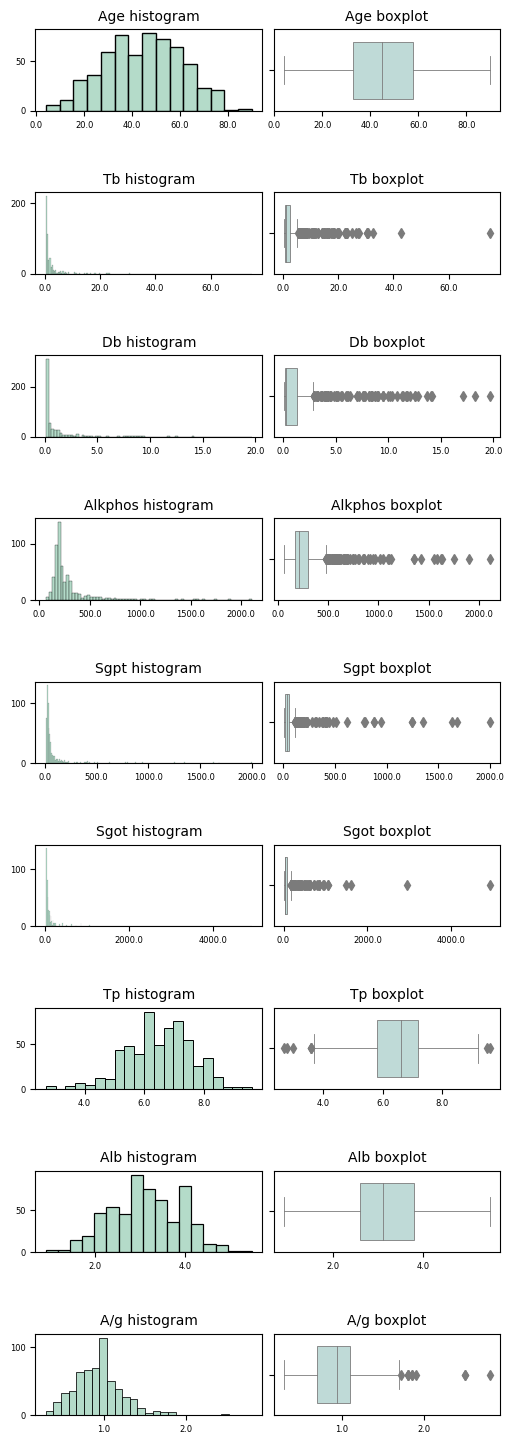

In [18]:
#visualisasikan data outlier ke dalam histogram dan boxpolot
plot_hist_box(liver_df[feature_numeric])

In [19]:
#hitung jumlah outlier masing masing kolom dengan menggunakan metode IQR dan tampilkan dalam tabel
def count_Outliers(X_num):
    indices = [x for x in X_num.index]
    out_indexlist = []
    outlier_tbl=[]
    for col in feature_numeric:
        q1 = np.percentile(X_num[col], 25)
        q3 = np.percentile(X_num[col], 75)
        iqr = q3 - q1
        lower = q1 - (iqr*1.5)
        upper = q3 + (iqr*1.5)
        outliers_index = X_num[col][(X_num[col] < lower) | (X_num[col] > upper)].index.tolist()
        outliers = X_num[col][(X_num[col] < lower) | (X_num[col] > upper)].values
        out_indexlist.extend(outliers_index)
        outlier_tbl.append({
            'Fitur': col,
            'Min': round(X_num[col].min(),1),
            'Q1': round(q1,1),
            'Mean': round(X_num[col].mean(),1),
            'Q3': round(q3,1),
            'Max': round(X_num[col].max(),1),
            'Lower': round(lower,1),
            'Upper': round(upper,1),
            'Jml Outlier': len(outliers),
        })
    print('\nNumber of rows with outliers: ', len(out_indexlist))
    out_df = pd.DataFrame(outlier_tbl,columns=['Fitur','Min','Q1','Mean','Q3','Max','Lower','Upper','Jml Outlier'])
    return out_df

In [20]:
count_Outliers(liver_df[feature_numeric])


Number of rows with outliers:  391


,Fitur,Min,Q1,Mean,Q3,Max,Lower,Upper,Jml Outlier
0,Age,4.0,33.0,44.7,58.0,90.0,-4.5,95.5,0
1,TB,0.4,0.8,3.3,2.6,75.0,-1.9,5.3,84
2,DB,0.1,0.2,1.5,1.3,19.7,-1.5,3.0,81
3,Alkphos,63.0,175.5,290.6,298.0,2110.0,-8.2,481.8,69
4,Sgpt,10.0,23.0,80.7,60.5,2000.0,-33.2,116.8,73
5,Sgot,10.0,25.0,109.9,87.0,4929.0,-68.0,180.0,66
6,TP,2.7,5.8,6.5,7.2,9.6,3.7,9.3,8
7,ALB,0.9,2.6,3.1,3.8,5.5,0.8,5.6,0
8,A/G,0.3,0.7,0.9,1.1,2.8,0.1,1.7,10


In [21]:
#handle outlier: jika outlier diatas upper diganti nilainya dengan nilai upper dan outlier dibawah lower diganti nilainya dengan lower
for c_kol in feature_numeric:
    q1 = np.percentile(liver_df[c_kol], 25)
    q3 = np.percentile(liver_df[c_kol], 75)
    iqr = q3 - q1
    lower = q1 - (iqr*1.5)
    upper = q3 + (iqr*1.5)
    liver_df[c_kol]= liver_df[c_kol].apply(lambda x: lower if x<lower else x)
    liver_df[c_kol] = liver_df[c_kol].apply(lambda x: upper if x>upper else x)

In [22]:
#tampilkan kembali jumlah outlier
count_Outliers(liver_df[feature_numeric])


Number of rows with outliers:  0


,Fitur,Min,Q1,Mean,Q3,Max,Lower,Upper,Jml Outlier
0,Age,4.0,33.0,44.7,58.0,90.0,-4.5,95.5,0
1,TB,0.4,0.8,1.9,2.6,5.3,-1.9,5.3,0
2,DB,0.1,0.2,0.9,1.3,3.0,-1.5,3.0,0
3,Alkphos,63.0,175.5,251.3,298.0,481.8,-8.2,481.8,0
4,Sgpt,10.0,23.0,47.9,60.5,116.8,-33.2,116.8,0
5,Sgot,10.0,25.0,64.8,87.0,180.0,-68.0,180.0,0
6,TP,3.7,5.8,6.5,7.2,9.3,3.7,9.3,0
7,ALB,0.9,2.6,3.1,3.8,5.5,0.8,5.6,0
8,A/G,0.3,0.7,0.9,1.1,1.7,0.1,1.7,0


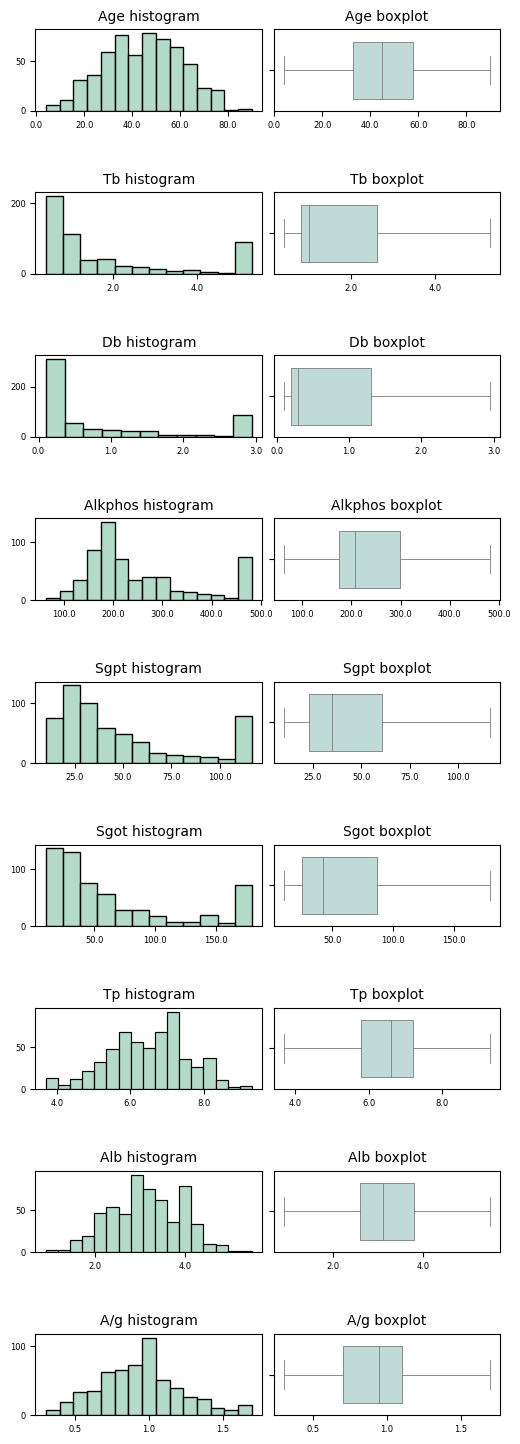

In [23]:
#visualkan kembali boxplotnya
plot_hist_box(liver_df[feature_numeric])

### Label Encoding

In [24]:
#Label Encoding
print('Gender->Male:1 dan Female:0')
liver_df['Gender'].replace({"Male":1 , "Female":0},inplace = True)
print('Class->Liver:1 dan Non-Liver:2')
liver_df['Class'].replace({"Liver":1 , "Non-Liver":2},inplace = True)
liver_df

Gender->Male:1 dan Female:0
Class->Liver:1 dan Non-Liver:2


,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G,Class
0,65,0,0.7,0.10,187.00,16.0,18.0,6.8,3.3,0.90,1
1,62,1,5.3,2.95,481.75,64.0,100.0,7.5,3.2,0.74,1
2,62,1,5.3,2.95,481.75,60.0,68.0,7.0,3.3,0.89,1
3,58,1,1.0,0.40,182.00,14.0,20.0,6.8,3.4,1.00,1
4,72,1,3.9,2.00,195.00,27.0,59.0,7.3,2.4,0.40,1
...,...,...,...,...,...,...,...,...,...,...,...
578,60,1,0.5,0.10,481.75,20.0,34.0,5.9,1.6,0.37,2
579,40,1,0.6,0.10,98.00,35.0,31.0,6.0,3.2,1.10,1
580,52,1,0.8,0.20,245.00,48.0,49.0,6.4,3.2,1.00,1
581,31,1,1.3,0.50,184.00,29.0,32.0,6.8,3.4,1.00,1


### Split data training dan testing

In [26]:
X=liver_df.drop(['Class'],axis = 1)
y=liver_df['Class']

In [27]:
#split data ke dalam data latih (80%) dan data Uji (20%)
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=123,stratify= y)
print(f'x_train: {x_train.shape}')
print(f'x_test: {x_test.shape}')

x_train: (466, 10)
x_test: (117, 10)


### Normalisasi Data

In [28]:
# Preprocessing dengan StandardScaler
x_train_scaler = StandardScaler().fit_transform(x_train)
x_test_scaler = StandardScaler().fit_transform(x_test)
x_train_scaler

array([[-0.41164924,  0.57239438, -0.56071816, ...,  0.72761168,
         1.53875446,  1.89367731],
       [ 1.82541833, -1.7470472 , -0.50019125, ...,  1.46271639,
         1.16541556,  0.18434926],
       [ 0.39618072,  0.57239438, -0.68177198, ...,  0.36005933,
         0.66763036,  0.52621487],
       ...,
       [ 0.64474378,  0.57239438, -0.68177198, ...,  0.45194742,
        -0.20349373, -0.84124757],
       [ 0.27189919,  0.57239438, -0.50019125, ...,  0.45194742,
         1.41430816,  1.89367731],
       [ 0.02333612, -1.7470472 ,  2.04193889, ...,  1.09516404,
         0.41873776, -0.49938196]])

### Resample Data

In [29]:
# SMOTE
smote_resample = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote_resample.fit_resample(x_train_scaler, y_train)
x_test_resampled, y_test_resampled = smote_resample.fit_resample(x_test_scaler, y_test)

### Modeling - Parameter KNN Default

In [50]:
knn_model_default = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski')
knn_model_default.fit(x_train_resampled, y_train_resampled)
y_pred_default = knn_model_default.predict(x_test_resampled)

### Tunning Hyperparameter Optuna

In [51]:
# Tuning Hyperparameter Optuna
def objective(trial):
    #knn parameter
    n_neighbors = trial.suggest_int("n_neighbors", 1,10)
    weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
    metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])

    #knn model
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)

    #cross_val_score
    #score = cross_val_score(knn_model, x_train_resampled, y_train_resampled, scoring='accuracy', cv=5)
    #score = score.mean()

      # Latih model dengan data latih
    knn_model.fit(x_train_resampled, y_train_resampled)

    # Prediksi label pada data uji
    y_pred = knn_model.predict(x_test_resampled)

    # Hitung akurasi prediksi
    accuracy = accuracy_score(y_test_resampled, y_pred)

    # Kembalikan akurasi sebagai skor optimasi
    return accuracy

    #return score

In [53]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-07-22 08:50:01,044] A new study created in memory with name: no-name-f3d2be72-ce32-46bf-9a68-879a25626779
[I 2023-07-22 08:50:01,055] Trial 0 finished with value: 0.6927710843373494 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: 0.6927710843373494.
[I 2023-07-22 08:50:01,067] Trial 1 finished with value: 0.6506024096385542 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.6927710843373494.
[I 2023-07-22 08:50:01,077] Trial 2 finished with value: 0.6746987951807228 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.6927710843373494.
[I 2023-07-22 08:50:01,087] Trial 3 finished with value: 0.6807228915662651 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.6927710843373494.
[I 2023-07-22 08:50:01,098] Trial 4 finished with value: 0.68072

### Optimization History Plot

In [54]:
optuna.visualization.plot_optimization_history(study)

### Hyperparameter Importances Optuna

In [55]:
optuna.visualization.plot_param_importances(study)

### Best Parameter Optuna

In [56]:
best_params = study.best_params
best_params

{'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}

### Create Model best Parameter

In [57]:
#model dengan best parameter
def create_model_best_params(best_params):
    best_n_neighbors =best_params['n_neighbors']
    best_weights =best_params['weights']
    best_metric =best_params['metric']
    knn_optuna=KNeighborsClassifier(n_neighbors=best_n_neighbors,weights=best_weights,metric=best_metric)
    return knn_optuna

In [58]:
knn_model_optuna=create_model_best_params(best_params)
knn_model_optuna.fit(x_train_resampled, y_train_resampled)
y_pred_optuna = knn_model_optuna.predict(x_test_resampled)

### Nilai Akurasi Model KNN Default

In [61]:
#counfussion metric
def plot_confusion_matrixs(actual,prediction):
    cm = confusion_matrix(actual,prediction)
    cm_df = pd.DataFrame(cm,index = ['Liver','Non-Liver'],columns = ['Liver','Non-Liver'])
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

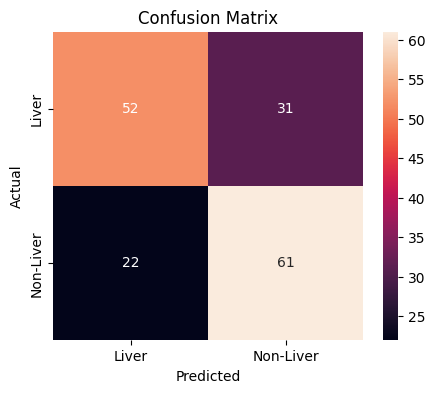

akurasi default:  0.68

Classification Report Default:
              precision    recall  f1-score   support

           1       0.70      0.63      0.66        83
           2       0.66      0.73      0.70        83

    accuracy                           0.68       166
   macro avg       0.68      0.68      0.68       166
weighted avg       0.68      0.68      0.68       166



In [62]:
plot_confusion_matrixs(y_test_resampled, y_pred_default)
accuracy_default = accuracy_score(y_test_resampled, y_pred_default)
class_report_default = classification_report(y_test_resampled, y_pred_default)
print(f'akurasi default:  {round(accuracy_default,2)}\n')
print("Classification Report Default:")
print(class_report_default)

### Nilai Akurasi Model KNN menggunakan Optuna

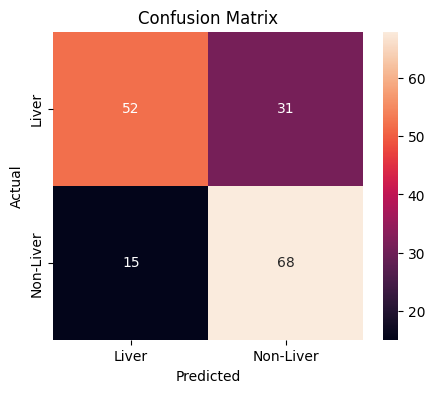

akurasi optuna:  0.72

Classification Report Optuna:
              precision    recall  f1-score   support

           1       0.78      0.63      0.69        83
           2       0.69      0.82      0.75        83

    accuracy                           0.72       166
   macro avg       0.73      0.72      0.72       166
weighted avg       0.73      0.72      0.72       166



In [63]:
plot_confusion_matrixs(y_test_resampled, y_pred_optuna)
accuracy_optuna = accuracy_score(y_test_resampled, y_pred_optuna)
class_report_optuna = classification_report(y_test_resampled, y_pred_optuna)
print(f'akurasi optuna:  {round(accuracy_optuna,2)}\n')
print("Classification Report Optuna:")
print(class_report_optuna)

### Perbandingan NIlai AKurasi model KNN dengan parameter Default dan Best Parameter Optuna

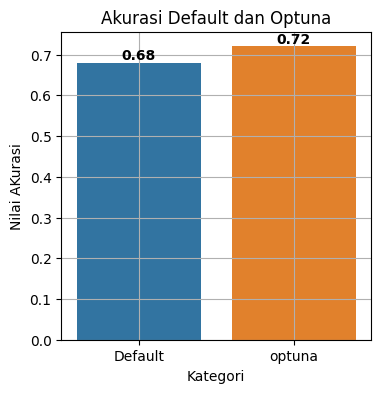

In [64]:
# Plot perbandingan akurasi default dan optuna
kategori_bar = ['Default', 'optuna']
nilai_bar = [round(accuracy_default,2),round(accuracy_optuna,2)]
# Mengatur ukuran plot
plt.figure(figsize=(4, 4))
# Menggunakan Seaborn untuk menggambarkan bar chart dengan nilai label
sns.barplot(x=kategori_bar, y=nilai_bar, palette='tab10')
# Menambahkan nilai label pada setiap bar
for index, value in enumerate(nilai_bar):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10, fontweight='bold')
# Menambahkan judul dan label pada sumbu x dan y
plt.title('Akurasi Default dan Optuna')
plt.xlabel('Kategori')
plt.ylabel('Nilai AKurasi')
# Menampilkan grid untuk memudahkan pembacaan
plt.grid(True)
# Menampilkan bar chart
plt.show()

In [66]:
selisih_akurasi=((accuracy_optuna-accuracy_default)/accuracy_default)*100
print(f'Selisih akurasi default dan optuna {round(selisih_akurasi,2)} %\n')

Selisih akurasi default dan optuna 6.19 %

